In [1]:
import zhusuan as zs
import tensorflow as tf
import numpy as np
import sys
from matplotlib import pyplot as plt
from zhusuan.variational import svgd
import seaborn as sns
%matplotlib inline

In [2]:
sess = tf.InteractiveSession()

In [3]:
@zs.reuse('model')
def mixture_of_gaussians(observed):
    with zs.BayesianNet(observed) as model:
        dA = zs.Normal(name='dA', mean=np.float32(3), std=np.float32(1))
        dB = zs.Normal(name='dB', mean=np.float32(-2), std=np.float32(0.5))
        switch = zs.Bernoulli(name='s', logits=np.float32(0), dtype=tf.float32)
        dist = switch * dA + (np.float32(1)-switch) * dB
    return model, dist

_, dist = mixture_of_gaussians(None)

dist_vals = tf.get_variable(
    'dist_v',
    [400],
    tf.float32,
    tf.random_uniform_initializer(-1, 1)
)

def log_joint(observed):
    m, d = mixture_of_gaussians(None)
    return tf.log(np.float32(0.5) * tf.exp(m.get('dA').distribution.log_prob(observed['dist'])) + \
        np.float32(0.5) * tf.exp(m.get('dB').distribution.log_prob(observed['dist'])))

grad_and_vars = svgd.stein_variational_gradient(
    log_joint, {'dist': dist_vals})
optimizer = tf.train.AdamOptimizer(0.01)
opt_op = optimizer.apply_gradients([(-g, v) for g, v in grad_and_vars])

/home/ziyu/zhusuan-dev/zhusuan/distributions/univariate.py:84: FutureWarning: Normal: The order of arguments logstd/std will change to std/logstd in the coming version.
  "to std/logstd in the coming version.", FutureWarning)


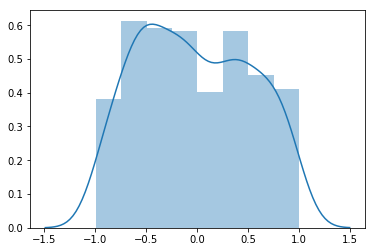

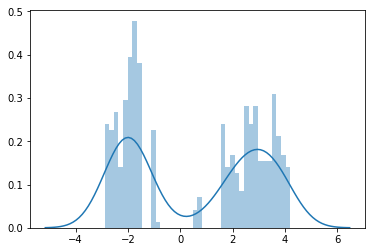

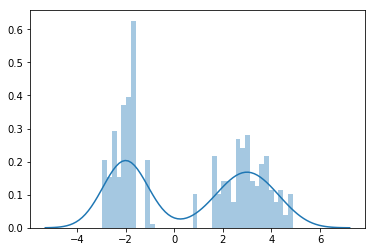

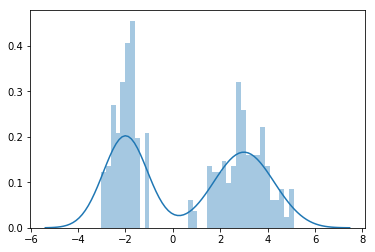

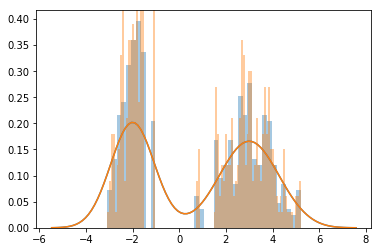

In [8]:
sess.run(tf.global_variables_initializer())

particles = sess.run(grad_and_vars[0][1])
# sns.jointplot(particles[:, 0], particles[:, 1])
sns.distplot(particles)
for j in range(4):
    for i in range(500):
        _, g, v = sess.run([opt_op, grad_and_vars[0][0], grad_and_vars[0][1]])
    plt.figure()
    sns.distplot(v, bins=40)

particles = sess.run(grad_and_vars[0][1])
# sns.jointplot(particles[:, 0], particles[:, 1])
sns.distplot(particles, bins=100)

/home/ziyu/zhusuan-dev/zhusuan/distributions/univariate.py:84: FutureWarning: Normal: The order of arguments logstd/std will change to std/logstd in the coming version.
  "to std/logstd in the coming version.", FutureWarning)


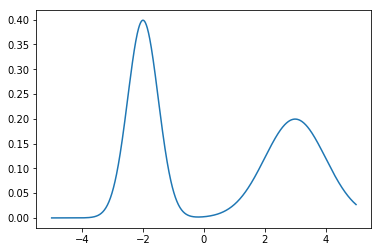

In [5]:
ax = np.linspace(-5, 5, 1000)
axes = tf.constant(ax, dtype=tf.float32)
plt.plot(ax, sess.run(tf.exp(log_joint({'dist':axes}))))

In [11]:
np.random.uniform(0, 1, [2, 1])<

array([[0.62040986],
       [0.13725029]])

In [15]:
n_covariates = 13

w_true = np.random.normal(size=[n_covariates, 1])
b_true = np.random.normal() * 0.5
X = np.random.uniform(-2, 2, size=[500, n_covariates])
Y_logits = np.squeeze(X @ w_true) + b_true
Y_prob = 1 / (1 + np.exp(-Y_logits))
Y = np.zeros((X.shape[0], ), dtype=np.int32)
Y[np.random.uniform(0, 1, size=[X.shape[0]]) < Y_prob] = 1

@zs.reuse('logistic_reg')
def logistic_regression(inp, observed):
    with zs.BayesianNet(observed) as model:
        w = zs.Normal(
            'w', 
            mean=tf.zeros([n_covariates, 1]),
            std=np.float32(1))
        b = zs.Normal(
            'b', 
            mean=np.float32(0),
            std=np.float32(1))
        logits = tf.squeeze(inp @ w, axis=-1) + b
        out = zs.Bernoulli('out', logits)
    return model

x_ph = tf.placeholder(tf.float32, [None, n_covariates])
y_ph = tf.placeholder(tf.int32, [None])

def log_joint(observed):
    model = logistic_regression(x_ph, observed)
    return tf.add_n(model.local_log_prob(['w', 'b', 'out']))

hmc = zs.HMC(step_size=1e-3, n_leapfrogs=20, adapt_step_size=True,
             target_acceptance_rate=0.6)
n_chain = 10
w_hmc = tf.Variable(tf.zeros([n_chain, n_covariates, 1]), name='w_hmc')
b_hmc = tf.Variable(tf.zeros([n_chain]), name='b_hmc')
sample_op, hmc_info = hmc.sample(
    log_joint, observed={'out': y_ph}, latent={'w': w_hmc, 'b': b_hmc})
hmc_T = 500
traces = np.zeros([hmc_T, n_chain, n_covariates+1, 1])
feed_dict = {x_ph: X, y_ph: Y}
for i in range(hmc_T):
    _, ws, bs, acc = sess.run(
        [sample_op, hmc_info.samples['w'], hmc_info.samples['b'], hmc_info.acceptance_rate])
    print('\r Iter {} Acc {}'.format(i, acc), end='')
    traces[i] = np.concatenate(ws, bs.reshape((-1, 1, 1)), axis=1)
print()

/home/ziyu/zhusuan-dev/zhusuan/distributions/univariate.py:84: FutureWarning: Normal: The order of arguments logstd/std will change to std/logstd in the coming version.
  "to std/logstd in the coming version.", FutureWarning)


TypeError: Normal.std(<dtype: 'int32'>), must be the same type as Normal.mean(<dtype: 'float32'>).

originally defined at:
  File "<ipython-input-15-80d3e758149e>", line 11, in <module>
    @zs.reuse('logistic_reg')
  File "/home/ziyu/zhusuan-dev/zhusuan/model/base.py", line 419, in <lambda>
    return lambda f: tf.make_template(scope, f)
